In [1]:
import os
os.chdir("/home/149/ab8992/tasman-tides")
# from recipes import surfacespeed
from importlib import reload
import ttidelib as tt
from ttidelib import logmsg
import shutil
import subprocess
import dask
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
experiment,outputs = "full-20","output*"
from dask.distributed import Client, default_client
from pathlib import Path
try:
    # Try to get the existing Dask client
    client = default_client()
except ValueError:
    # If there's no existing client, create a new one
    client = Client()

client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40791 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40791/status,
Dashboard: /proxy/40791/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42517,Workers: 7
Dashboard: /proxy/40791/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33241,Total threads: 4
Dashboard: /proxy/35627/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34659,


## Test improving collect data so it only looks at the right output files for time slice

In [9]:
def collect_data(exptname,rawdata = None,ppdata = None,surface_data = None,chunks = None,timerange = (None,None)):
    """
    Collect all data required for analysis into a single xarray.Dataset
    expname : str
        Name of the experiment
    rawdata : list of str
        List of raw data variables to include
    ppdata : list of str
        List of postprocessed data variables to include. Note that thse aren't organised in to "outputs" given that they are often filtered temporally and so don't fit within the same output bins as model runs
    outputs : str
        Glob string to match the output directories
    chunks : dict
        Chunks to use for dask. If "auto", use the default chunking for each variable. Surface variables are only given a time chunk
    timerange : Can choose the times instead of output. If None, use all times
    """

    res = exptname.split("-")[-1]

    if res == "20":
        time_per_output = 15 * 24
    elif res == "40":
        time_per_output = 5 * 24

    outputs = np.arange(
        np.floor(timerange[0] /time_per_output),
        np.ceil(timerange[1] / time_per_output)
    ).astype(int)
    # change these outputs to strings with 3 digits
    rawdata_paths = [f"/g/data/nm03/ab8992/outputs/{exptname}/output{i:03d}" for i in outputs]

    ppdata_path = Path("/g/data/nm03/ab8992/postprocessed/") / exptname


    data = {}
    if type(rawdata) != type(None):
        
        for var in rawdata:
            print(f"loading {var}...",end = "\t" )

            # Collect list of files to load
            all_files = []
            # Loop over each path in the paths list
            for path in rawdata_paths:
                # Convert the path to a Path object
                path = Path(path) / var
                # Use glob to find all files that match the pattern
                files = list(path.glob('*.nc'))
                # Add the files to the all_files list
                all_files.extend(files)

            # Now pass all the files instead of a wildcard string
            data[var] = xr.open_mfdataset(all_files, decode_times=False, parallel=True, decode_cf=False).sel(time = slice(timerange[0],timerange[1]))[var]
            
            print("done.")

        # #! I messed up the rotation! This fixes the velocity rotation on data load.
        # if "u" in rawdata and "v" in rawdata:
        #     u_rotated_once,v_rotated_once = anticlockwise_rotation(data["u"],data["v"])
        #     u_rotated_once, v_rotated_once = anticlockwise_rotation(u_rotated_once,v_rotated_once)

        #     data["u"] = u_rotated_once.rename("u")
        #     data["v"] = v_rotated_once.rename("v")

    if type(ppdata) != type(None):
        for var in ppdata:
            print(f"loading {var} topdown...",end = "\t" )
            data[var + "_topdown"] = xr.open_mfdataset(
                str(ppdata_path / var / "topdown" / "*.nc"),chunks = chunks,decode_times = False,parallel = True,decode_cf = False).sel(time = slice(timerange[0],timerange[1])
            )[var].rename(f"{var}_topdown")
            print("done. loading transect...",end = "\t")
            data[var + "_transect"] = xr.open_mfdataset(
                str(ppdata_path / var / "transect" / "*.nc"),chunks = chunks,decode_times = False,parallel = True,decode_cf = False).sel(time = slice(timerange[0],timerange[1])
            )[var].rename(f"{var}_transect")
            print("done.")



    data["bathy"] = xr.open_mfdataset(str(Path("/g/data/nm03/ab8992/outputs/") / exptname / "bathy_transect.nc")).rename({"elevation":"bathy"})


    data = xr.merge([data[i] for i in data])

    return data



In [5]:
timerange = (30000,31000)
exptname,rawdata = "full-20",["u"]
var = "u"
res = exptname.split("-")[-1]

if res == "20":
    time_per_output = 15 * 24

outputs = np.arange(
    np.floor(timerange[0] /time_per_output),
    np.ceil(timerange[1] / time_per_output)
).astype(int)
# change these outputs to strings with 3 digits
rawdata_paths = [f"/g/data/nm03/ab8992/outputs/{exptname}/output{i:03d}" for i in outputs]


from pathlib import Path

# Initialize an empty list to store the file paths
all_files = []
# Loop over each path in the paths list
for path in rawdata_paths:
    # Convert the path to a Path object
    path = Path(path) / var
    # Use glob to find all files that match the pattern
    files = list(path.glob('*.nc'))
    # Add the files to the all_files list
    all_files.extend(files)

# Now you can pass all_files to open_mfdataset
xr.open_mfdataset(all_files, decode_times=False, parallel=True, decode_cf=False).sel(time = slice(timerange[0],timerange[1]))


<xarray.Dataset>
Dimensions:  (zl: 100, time: 1001, xb: 376, yb: 101)
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * time     (time) float64 3e+04 3e+04 3e+04 3e+04 ... 3.1e+04 3.1e+04 3.1e+04
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
Data variables:
    lon      (time, yb, xb) float64 dask.array<chunksize=(241, 6, 376), meta=np.ndarray>
    lat      (time, yb, xb) float64 dask.array<chunksize=(241, 6, 376), meta=np.ndarray>
    u        (time, zl, yb, xb) float32 dask.array<chunksize=(241, 100, 6, 376), meta=np.ndarray>

In [11]:
tt.collect_data(exptname,rawdata = "u",timerange = timerange)


loading u...	done.


<xarray.Dataset>
Dimensions:  (zl: 100, time: 1001, xb: 376, yb: 101)
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * time     (time) float64 3e+04 3e+04 3e+04 3e+04 ... 3.1e+04 3.1e+04 3.1e+04
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
    lon      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
    lat      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Data variables:
    u        (time, zl, yb, xb) float32 dask.array<chunksize=(241, 100, 6, 376), meta=np.ndarray>
    bathy    (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Attributes:
    _FillValue:   nan
    long_name:    Velocity along beam (Eastward positive)
    coordinates:  lat lon

In [10]:
collect_data(exptname,rawdata = "u",timerange = timerange)

loading u...	done.
0.3.0


<xarray.Dataset>
Dimensions:  (zl: 100, time: 1001, xb: 376, yb: 101)
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * time     (time) float64 3e+04 3e+04 3e+04 3e+04 ... 3.1e+04 3.1e+04 3.1e+04
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
    lon      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
    lat      (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Data variables:
    u        (time, zl, yb, xb) float32 dask.array<chunksize=(241, 100, 6, 376), meta=np.ndarray>
    bathy    (yb, xb) float64 dask.array<chunksize=(101, 376), meta=np.ndarray>
Attributes:
    _FillValue:   nan
    long_name:    Velocity along beam (Eastward positive)
    coordinates:  lat lon

In [10]:
xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/{exptname}/output*/{var}/*.nc", decode_times=False, parallel=True, decode_cf=False).sel(time = slice(timerange[0],timerange[1]))


<xarray.Dataset>
Dimensions:  (zl: 100, time: 1001, xb: 376, yb: 101)
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * time     (time) float64 3e+04 3e+04 3e+04 3e+04 ... 3.1e+04 3.1e+04 3.1e+04
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
Data variables:
    lon      (time, yb, xb) float64 dask.array<chunksize=(241, 6, 376), meta=np.ndarray>
    lat      (time, yb, xb) float64 dask.array<chunksize=(241, 6, 376), meta=np.ndarray>
    u        (time, zl, yb, xb) float32 dask.array<chunksize=(241, 100, 6, 376), meta=np.ndarray>

## Find non advective bottom cells

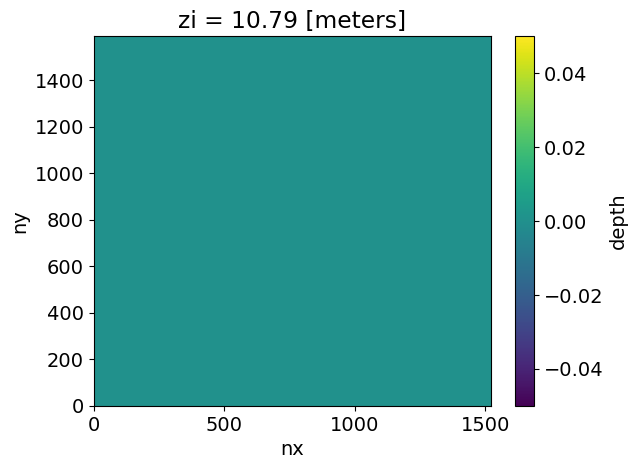

In [70]:
topo = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/blank-40/topog.nc",chunks = "auto")
depth = topo.depth.load()
scored = np.sign(depth - depth.roll(nx=-1,roll_coords=False)) 
scored += np.sign(depth - depth.roll(nx=1,roll_coords=False))
scored += np.sign(depth - depth.roll(ny=-1,roll_coords=False))
scored += np.sign(depth - depth.roll(ny=1,roll_coords=False))

holes = scored.where(scored == -4,0) * - 0.25
holes[0,:] = 0
holes[-1,:] = 0
holes[:,0] = 0
holes[:,-1] = 0
holes.plot()

In [2]:
topo = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/blank-40/topog_raw.nc",chunks = "auto")


0.3.0


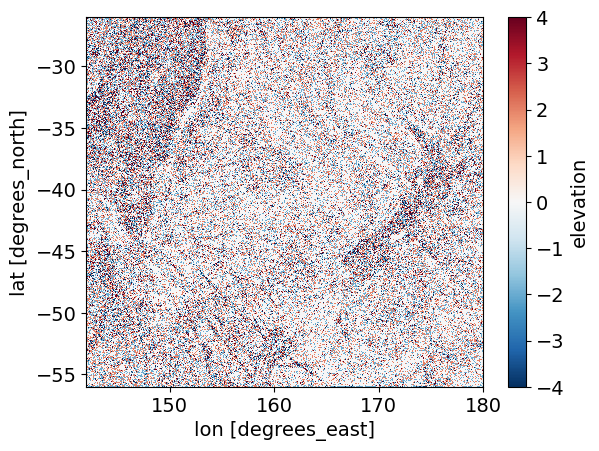

In [13]:
%matplotlib inline
plt.show()

## Plot all potholes:

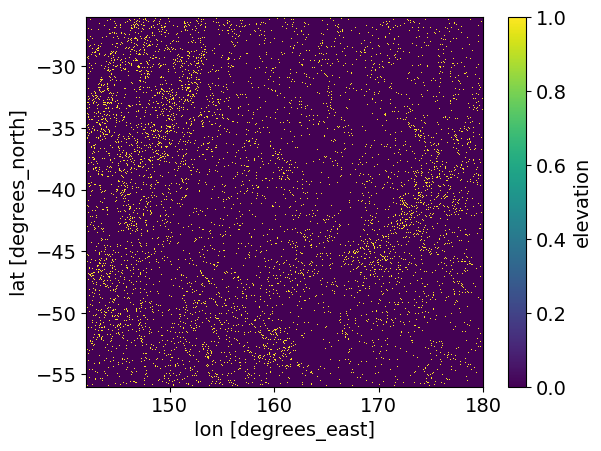

In [53]:
## use Find all the points in topo that are lower than all 4 neighbours
scored = np.sign(topo - topo.roll(lon=-1,roll_coords=False)) 
scored += np.sign(topo - topo.roll(lon=1,roll_coords=False))
scored += np.sign(topo - topo.roll(lat=-1,roll_coords=False))
scored += np.sign(topo - topo.roll(lat=1,roll_coords=False))

holes = scored.where(scored == -4,0) * - 0.25
holes[0,:] = 0
holes[-1,:] = 0
holes[:,0] = 0
holes[:,-1] = 0
holes.plot()

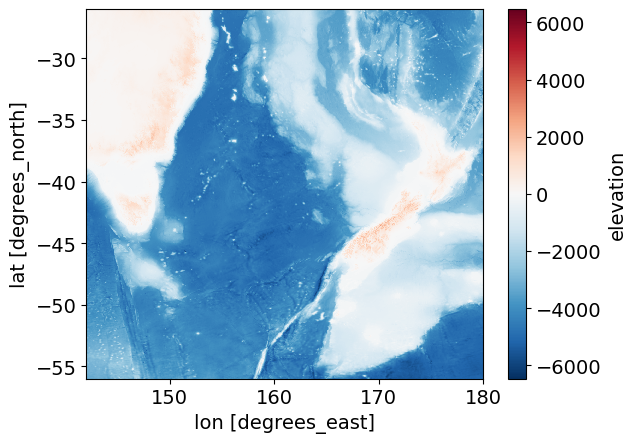

In [40]:
# topo = topo.elevation.load()
topo.plot()

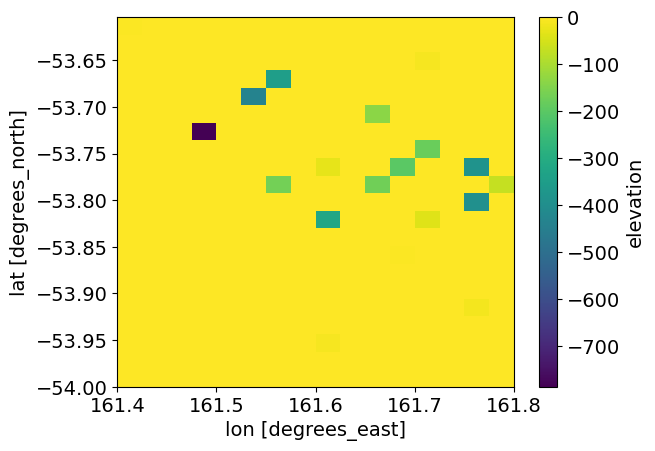

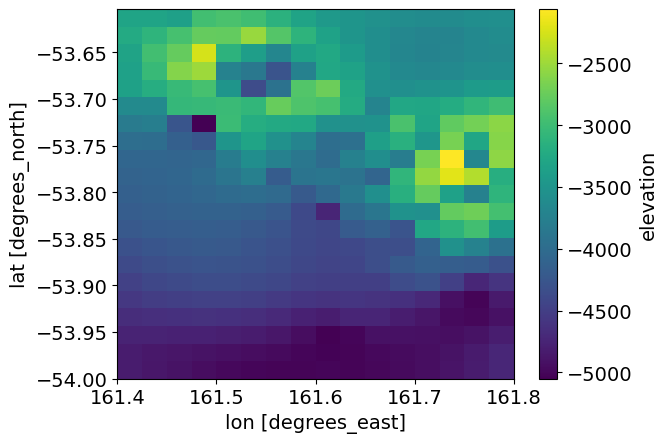

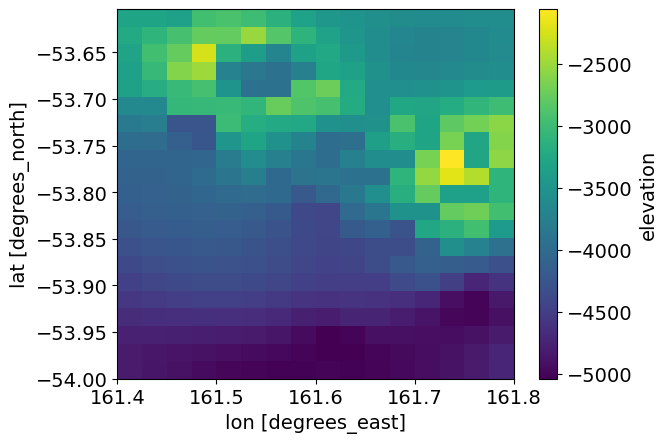

In [67]:
import xarray as xr
import numpy as np

# Assuming `topo` is your DataArray
zeros = xr.DataArray(np.zeros_like(topo), dims=topo.dims, coords=topo.coords)

arrays = [
    holes * (1 * topo - topo.roll(lon=-1, roll_coords=False)), ## These values are now negative
    holes * (1 * topo - topo.roll(lon=1, roll_coords=False)),
    holes * (1 * topo - topo.roll(lat=-1, roll_coords=False)),
    holes * (1 * topo - topo.roll(lat=1, roll_coords=False))
]

minmap = xr.concat(arrays, dim='new_dim').max('new_dim')

lon = slice(161.4,161.8)
lat = slice(-54,-53.6)
# lon = slice(None,None)
# lat = slice(None,None)

minmap.sel(lon = lon,lat = lat).plot()
plt.figure()
topo.sel(lon = lon,lat = lat).plot()
plt.figure()
filled_in = topo - minmap
filled_in.sel(lon = lon,lat = lat).plot()

## Now use normal library to remake topog based on new topog_raw

In [87]:
os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")
import regional_mom6 as rm

ImportError: attempted relative import with no known parent package

In [82]:

yextent = [-56,-26]
xextent = [142,180]
expt_name = "nonoles-full-40"

# 
daterange = ["2015-01-01 00:00:00", "2015-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/ttide-20"
# tmpdir = f"/home/149/ab8992/tasman-tides/rundirs/full-20/inputdir/forcing"
# tmpdir = "/home/149/ab8992/tasman-tides/rundirs/mkic/archive/output000/"
## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.025,  ## Resolution
    100,      ## #zlayers
    20,       ## dz ratio
    5500,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)
expt.bathymetry(
    None,None,False,maketopog = False
)

ImportError: attempted relative import with no known parent package

# Troubleshoot rotated velocities

Eddies look weird and rotated in plots of u and v. There's an angled axis. Check what happens to a totally zonal flow after being passed through our beamgrid function

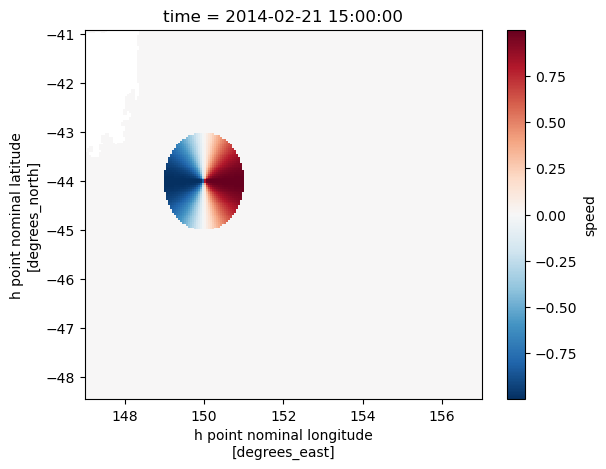

In [29]:
v_basegrid.isel(xh = slice(100,300),yh = slice(200,400)).plot()

## Put said eddy through the beamgrid

/jobfs/110769140.gadi-pbs/ipykernel_2985922/2556397929.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdBu_r')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable speed as the horizontal dimensions for the regridding.
  warnings.warn(


Text(0.5, 0.98, 'Meridional / Across beam velocity')

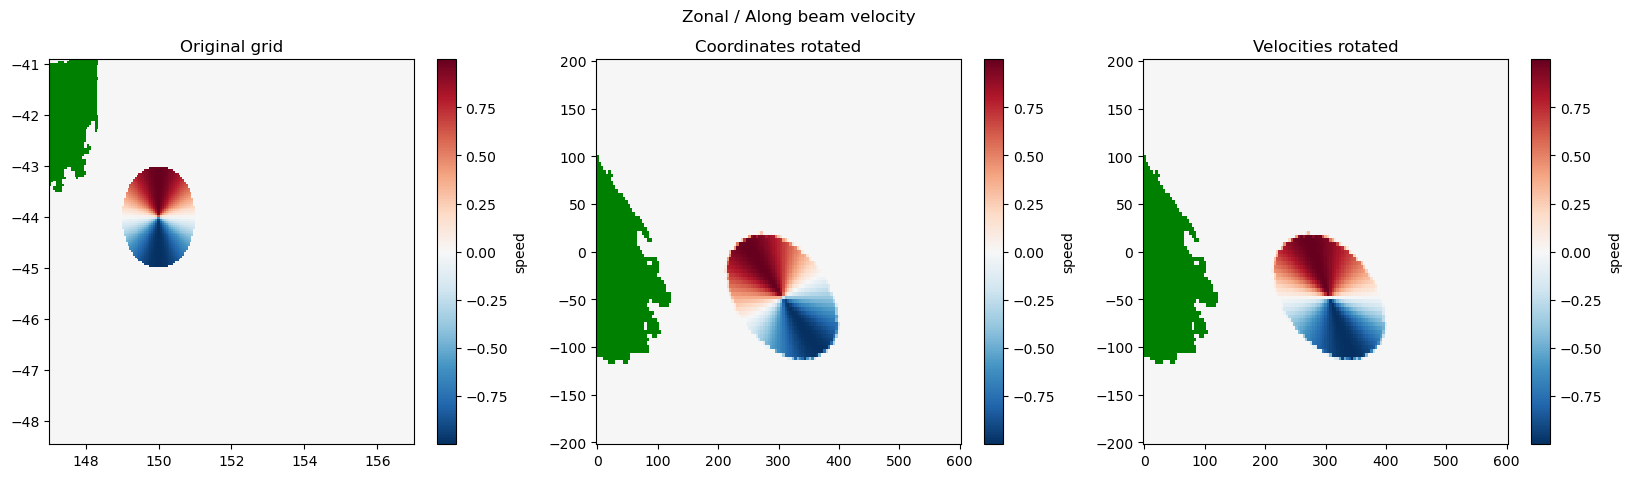

<Figure size 640x480 with 0 Axes>

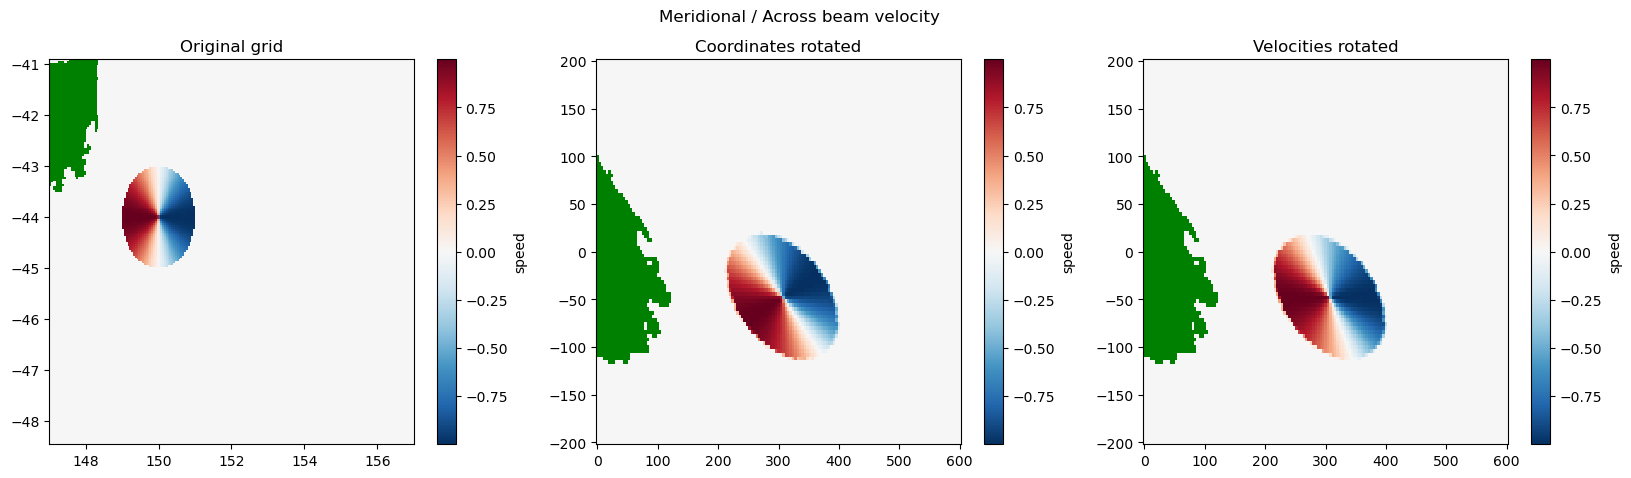

In [48]:
# theta *= -1 ## Look, I just did some trial and error until the beam was in the right quadrant. Who needs year 10 maths
import matplotlib
cmap = matplotlib.cm.get_cmap('RdBu_r')

## Set up the dummy eddy

import numpy as np

#Make an eddy in the base grid
# basegrid = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/output100/surface.nc").isel(time = 50).speed * 0

xh , yh = np.meshgrid(basegrid.xh.values,basegrid.yh.values)
x0,y0 =  150,-44
radius = 1
theta = np.arctan((yh - y0)/(xh - x0)) 
# Use a where statement that places conditions on xh and yh
theta = np.where((xh - x0 < 0) * (yh - y0 > 0),1 * np.pi + theta,theta)
theta = np.where((xh - x0 < 0) * (yh - y0 < 0),1 * np.pi+ theta,theta)
theta = np.where((xh - x0 > 0) * (yh - y0 < 0),2 * np.pi + theta,theta)
u = np.where((xh - x0)**2 + (yh - y0)**2 < radius,np.sin(theta),0)
v = -1 * np.where((xh - x0)**2 + (yh - y0)**2 < radius,np.cos(theta),0)

# v *= 0

# Set the color for NaN values
cmap.set_bad(color='green')
u_basegrid = basegrid * 0 + u
v_basegrid = basegrid * 0 + v

u_beamgrid = tt.beamgrid(u_basegrid,xname = "xh")
v_beamgrid = tt.beamgrid(v_basegrid,yname = "yh")

# Clockwise rotation
theta = -1 * np.arctan((-43.3 + 49.8) / -17) #! Hardcoded. This comes out to -20.9 degrees

# u2 = u_beamgrid * np.cos(theta) + v_beamgrid * np.sin(theta)
# v2 = -u_beamgrid * np.sin(theta) + v_beamgrid * np.cos(theta)

# Old rotation
u2 = u_beamgrid * np.cos(theta) - v_beamgrid * np.sin(theta)
v2 = u_beamgrid * np.sin(theta) + v_beamgrid * np.cos(theta)

fig,ax = plt.subplots(1,3,figsize = (20,5))
u_basegrid.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[0],cmap = cmap)

u_beamgrid.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[1],cmap = cmap)
u2.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)
for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Original grid")
ax[1].set_title("Coordinates rotated")
ax[2].set_title("Velocities rotated")
fig.suptitle("Zonal / Along beam velocity")

plt.figure()
fig,ax = plt.subplots(1,3,figsize = (20,5))
v_basegrid.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[0],cmap = cmap)


v_beamgrid.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[1],cmap = cmap)
v2.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)

for i in range(3):
    ax[i].set_title("")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Original grid")
ax[1].set_title("Coordinates rotated")
ax[2].set_title("Velocities rotated")
fig.suptitle("Meridional / Across beam velocity")


## Rotate velocities first instead

/jobfs/110769140.gadi-pbs/ipykernel_2985922/2157723213.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdBu_r')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable speed as the horizontal dimensions for the regridding.
  warnings.warn(


Text(0.5, 0.98, 'Meridional / Across beam velocity')

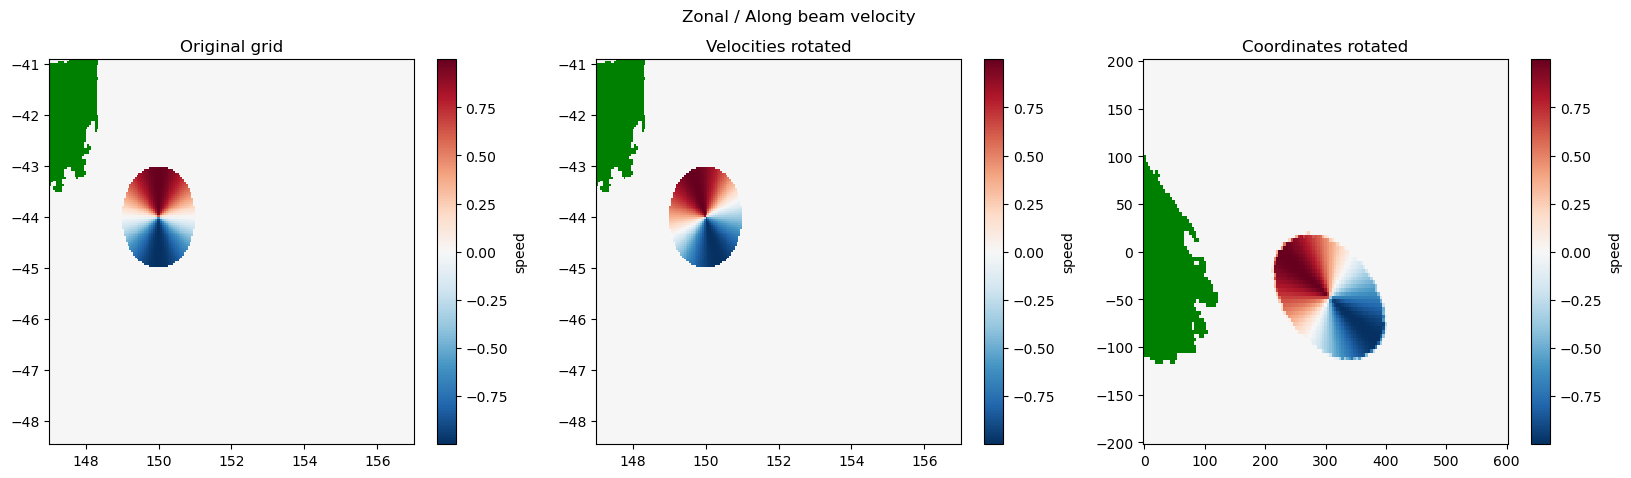

<Figure size 640x480 with 0 Axes>

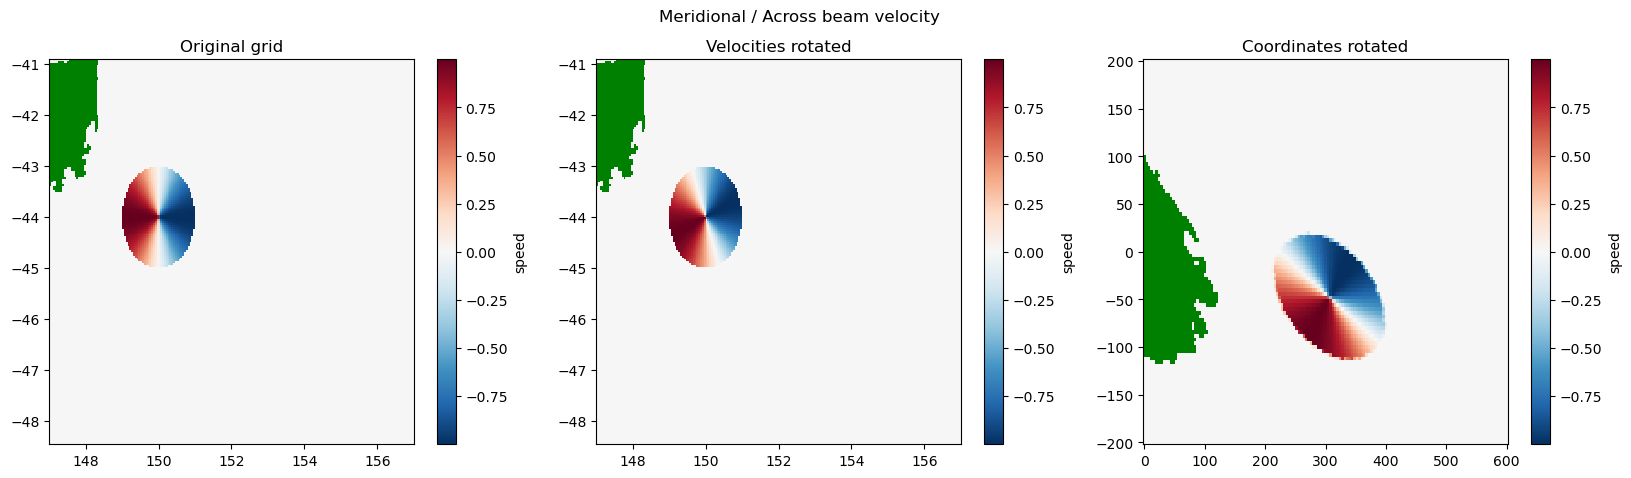

In [62]:
theta = np.arctan((-43.3 + 49.8) / -17) #! Hardcoded. This comes out to -20.9 degrees
# theta *= -1 ## Look, I just did some trial and error until the beam was in the right quadrant. Who needs year 10 maths
import matplotlib
cmap = matplotlib.cm.get_cmap('RdBu_r')

# Set the color for NaN values
cmap.set_bad(color='green')
u_basegrid = u_basegrid * 0 + u
v_basegrid = u_basegrid * 0 + v

# u_basegrid *= 0

# Counterclockwise Rotation
u_rotated = u_basegrid * np.cos(theta) - v_basegrid * np.sin(theta)
v_rotated = u_basegrid * np.sin(theta) + v_basegrid * np.cos(theta)

u_beamgrid = tt.beamgrid(u_rotated,xname = "xh")
v_beamgrid = tt.beamgrid(v_rotated,yname = "yh")



fig,ax = plt.subplots(1,3,figsize = (20,5))
u_basegrid.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[0],cmap = cmap)
u_rotated.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[1],cmap = cmap)

u_beamgrid.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)
for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Original grid")
ax[2].set_title("Coordinates rotated")
ax[1].set_title("Velocities rotated")
fig.suptitle("Zonal / Along beam velocity")

plt.figure()
fig,ax = plt.subplots(1,3,figsize = (20,5))
v_basegrid.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[0],cmap = cmap)
v_rotated.isel(xh = slice(100,300),yh = slice(200,400)).plot(ax = ax[1],cmap = cmap)


v_beamgrid.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)

for i in range(3):
    ax[i].set_title("")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Original grid")
ax[2].set_title("Coordinates rotated")
ax[1].set_title("Velocities rotated")
fig.suptitle("Meridional / Across beam velocity")


## See steps necessary to fix falsely rotated velocities?

/jobfs/110769140.gadi-pbs/ipykernel_2985922/1704165964.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdBu_r')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable speed as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable speed as the horizontal dimensions for the regridding.
  warnings.warn(


Text(0.5, 0.98, 'Zonal / Along beam velocity')

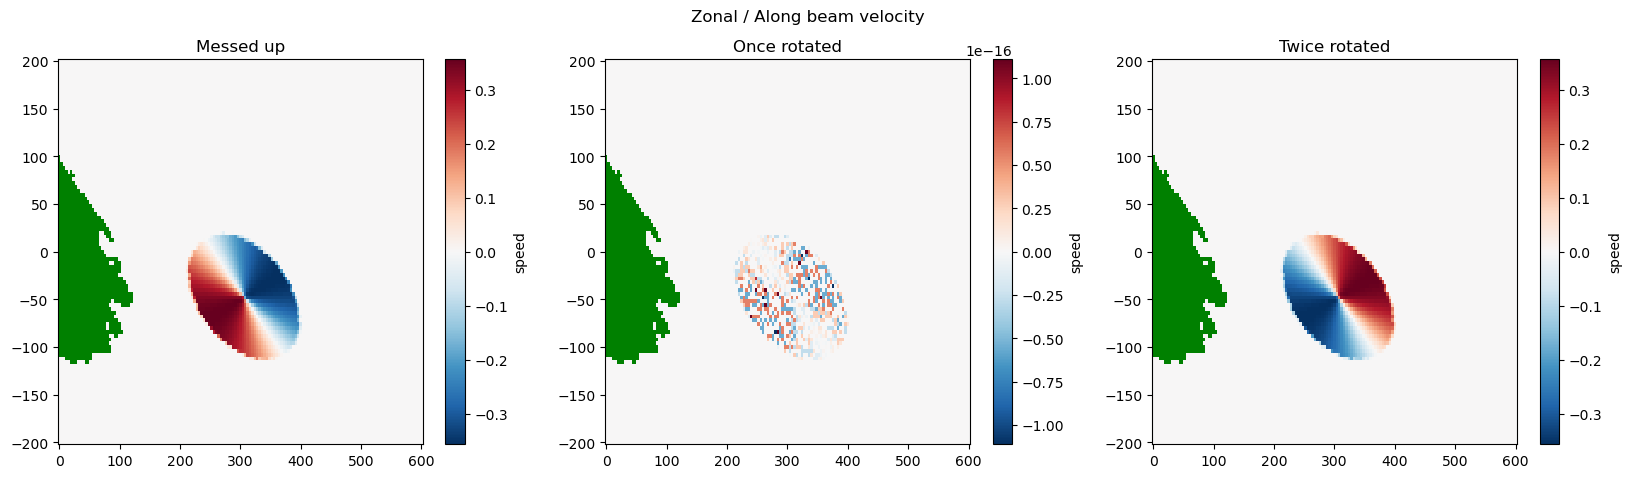

<Figure size 640x480 with 0 Axes>

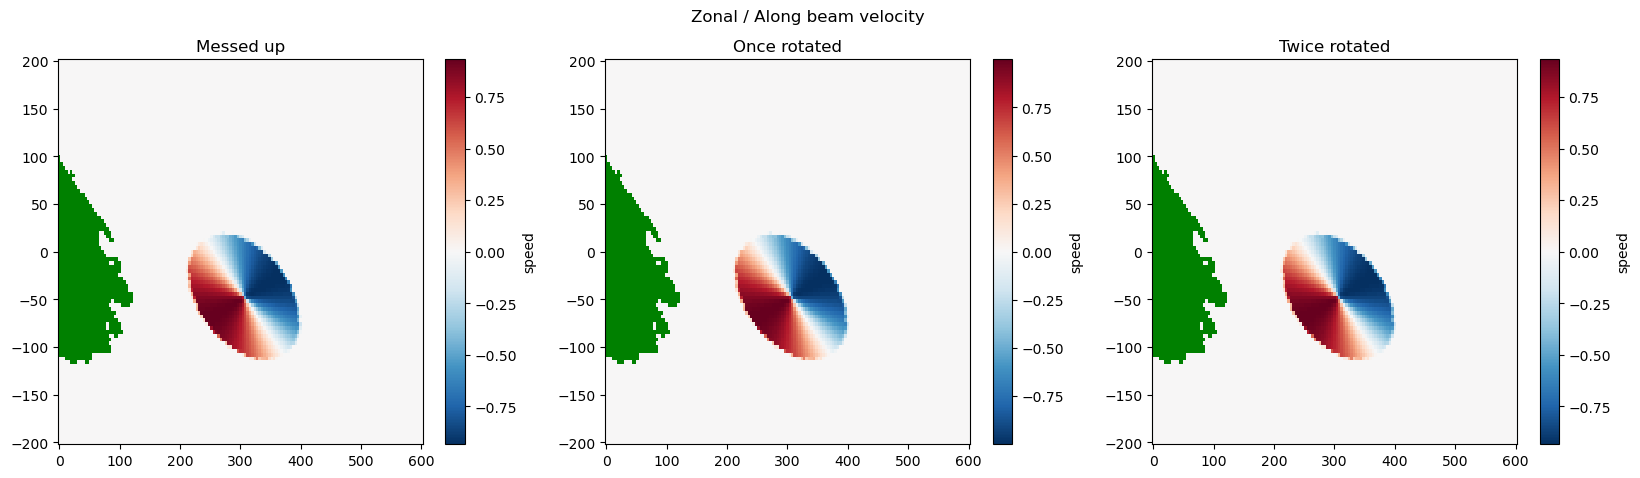

In [63]:
theta = 1 * np.arctan((-43.3 + 49.8) / -17) #! Hardcoded. This comes out to -20.9 degrees

import matplotlib
cmap = matplotlib.cm.get_cmap('RdBu_r')

# Set the color for NaN values
cmap.set_bad(color='green')
u_basegrid = u_basegrid * 0 + u
v_basegrid = u_basegrid * 0 + v

u_basegrid *= 0

# Counterclockwise Rotation
u_messed_up = tt.beamgrid(u_basegrid * np.cos(theta) - v_basegrid * np.sin(theta),xname = "xh")
v_messed_up = tt.beamgrid(u_basegrid * np.sin(theta) + v_basegrid * np.cos(theta),yname = "yh")

def anticlockwise_rotation(x,y,theta):
    theta = np.abs(theta)
    x_rotated = x * np.cos(theta) - y * np.sin(theta)
    y_rotated = x * np.sin(theta) + y * np.cos(theta)
    return x_rotated,y_rotated


u_rotated_once,v_rotated_once = anticlockwise_rotation(u_messed_up,v_messed_up,theta)
u_rotated_twice, v_rotated_twice = anticlockwise_rotation(u_rotated_once,v_rotated_once,theta)


fig,ax = plt.subplots(1,3,figsize = (20,5))

u_messed_up.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[0],cmap = cmap)
u_rotated_once.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[1],cmap = cmap)
u_rotated_twice.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)
for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Messed up")
ax[1].set_title("Once rotated")
ax[2].set_title("Twice rotated")
fig.suptitle("Zonal / Along beam velocity")

plt.figure()
fig,ax = plt.subplots(1,3,figsize = (20,5))

v_messed_up.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[0],cmap = cmap)
v_rotated_once.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[1],cmap = cmap)
v_rotated_twice.sel(xb = slice(0,600),yb = slice(-300,300)).plot(ax = ax[2],cmap = cmap)
for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title("Messed up")
ax[1].set_title("Once rotated")
ax[2].set_title("Twice rotated")
fig.suptitle("Zonal / Along beam velocity")
